In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from simcodes.fitters import ExtendedLS
from gatspy.periodic import LombScargleMultiband

In [2]:
### Integrating with period determination
library=pd.read_csv('simcodes/ZTF_VS_all_formatted.csv',index_col=0)
library['unique_filts_']=library['unique_filts_'].apply(lambda x:list(map(eval,x[1:-1].split(' '))))
library['ymean_by_filt_']=library['ymean_by_filt_'].apply(lambda x:np.array([float(k) for k in x[1:-1].split(' ') if len(k)>0]))
library['theta']=library['theta'].apply(lambda x:np.array([float(k) for k in x[1:-1].split(' ') if len(k)>0]))

In [3]:
def determinePeriod(row,missingData:bool=True,numPoints=60,frac:float=0.3,plot:bool=True)->float:
    """
    Determine period for a simulated light curve 'observed' with a given cadence. Credits for the simcode and 
    LCs to Kresimir Tisanic
    """
    tt=[]
    p=row['_best_period']
    tt.append(np.linspace(0,p*5,numPoints))
    
    if missingData==True:
        rem=(tt[0]%p)/p
        i=0
        while i<=round(1-frac,2):
            t=np.delete(tt[0],(rem>i) & (rem<(i+frac)))
            i+=0.1
            tt.append(t)
    periodMin=p*0.1
    periodMax=p*2.1
    pp={}
    if plot==True:
        fig=plt.figure(figsize=(5,5))
        subplot=fig.add_subplot(1,1,1)
    for i,t in enumerate(tt):
        filts=[row['unique_filts_'][0]]*len(t)
        ext=ExtendedLS(fit_period=True,optimizer_kwds=dict(quiet=True),Nterms_base=row['Nterms'])
        ext.import_parameters(row)
        mags = ext.predict(t=t,filts=filts)
        magErrs=0.1*mags
        ext.optimizer.period_range = (periodMin, periodMax)
        p=ext.fit(t,mags,magErrs,filts).best_period
        if plot==True:
            subplot.scatter((t%p)/p,mags,s=1,label=str(i))
        pp['detectedPeriod_'+str(i)]=p
        pp['phase_'+str(i)]=(t%p)/p
        pp['mags_'+str(i)]=mags
    if plot==True:
        plt.legend()
    return pp

In [4]:
libraryShort=library.iloc[0:3]

In [30]:
outputs={}
summary=pd.DataFrame(columns=['numPoints','frac','maxRatio','stdRatio'])
for numPoints in range(30,70,2):
    perDetermine={}
    print(numPoints,': ',end='')
    for frac in np.linspace(0.3,0.8,6):
        frac=round(frac,1)
        print(frac,end=' ')
        libraryOutput=libraryShort.apply(lambda row:determinePeriod(row,frac=frac,
                                                           plot=False,
                                                           numPoints=numPoints), 
                                                           axis=1, result_type='expand')
        workCols=[c for c in libraryOutput.columns if 'detectedPeriod' in c]
        libraryOutput2=libraryOutput[workCols].div(libraryOutput['detectedPeriod_0'],axis=0)
        libraryOutput2=libraryOutput2.rename({c:c.replace('detectedPeriod','periodRatio') for c in libraryOutput2.columns},
                                             axis='columns')
        
        workCols=[c for c in libraryOutput2.columns if 'periodRatio' in c]
        libraryOutput2['maxRatio']=libraryOutput2[workCols].abs().max(axis='columns',skipna=True)
        libraryOutput2['minRatio']=libraryOutput2[workCols].abs().min(axis='columns',skipna=True)
        libraryOutput2['std']=libraryOutput2[workCols].std(axis='columns',skipna=True)
        for c in libraryOutput.columns: 
            if 'phase' or 'mags' in c:
                libraryOutput2[c]=libraryOutput[c]
        
        perDetermine[frac]=libraryOutput2
        rec={'numPoints':numPoints,'frac':frac,
             'maxRatio':round(libraryOutput2['maxRatio'].max(),4),
             'minRatio':round(libraryOutput2['minRatio'].min(),4),
             'stdRatio':round(libraryOutput2['std'].max(),4)}
        summary=summary.append(rec,ignore_index=True)
    print('')
    outputs[numPoints]=perDetermine

30 : 0.3 0.4 0.5 0.6 0.7 0.8 
32 : 0.3 0.4 0.5 0.6 0.7 0.8 
34 : 0.3 0.4 0.5 0.6 0.7 0.8 
36 : 0.3 0.4 0.5 0.6 0.7 0.8 
38 : 0.3 0.4 0.5 0.6 0.7 0.8 
40 : 0.3 0.4 0.5 0.6 0.7 0.8 
42 : 0.3 0.4 0.5 0.6 0.7 0.8 
44 : 0.3 0.4 0.5 0.6 0.7 0.8 
46 : 0.3 0.4 0.5 0.6 0.7 0.8 
48 : 0.3 0.4 0.5 0.6 0.7 0.8 
50 : 0.3 0.4 0.5 0.6 0.7 0.8 
52 : 0.3 0.4 0.5 0.6 0.7 0.8 
54 : 0.3 0.4 0.5 0.6 0.7 0.8 
56 : 0.3 0.4 0.5 0.6 0.7 0.8 
58 : 0.3 0.4 0.5 0.6 0.7 0.8 
60 : 0.3 0.4 0.5 0.6 0.7 0.8 
62 : 0.3 0.4 0.5 0.6 0.7 0.8 
64 : 0.3 0.4 0.5 0.6 0.7 0.8 
66 : 0.3 0.4 0.5 0.6 0.7 0.8 
68 : 0.3 0.4 0.5 0.6 0.7 0.8 


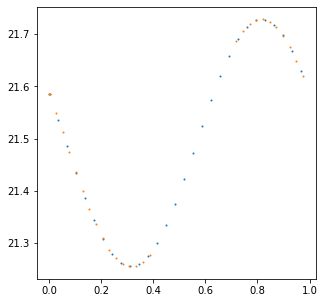

In [58]:
numPoints=30
frac=0.3
fig,ax=plt.subplots(figsize=(5,5))
ax.scatter(outputs[numPoints][frac].iloc[0]['phase_0'],outputs[numPoints][frac].iloc[0]['mags_0'],s=1)
ax.scatter(outputs[40][frac].iloc[0]['phase_4'],outputs[40][frac].iloc[0]['mags_4'],s=1)

In [32]:
summary

,numPoints,frac,maxRatio,stdRatio,minRatio
0,30.0,0.3,4.7993,1.2972,0.7059
1,30.0,0.4,4.7993,1.3620,0.7059
2,30.0,0.5,4.8003,1.8541,0.7059
3,30.0,0.6,1.0000,0.1201,0.7059
4,30.0,0.7,1.0000,0.1470,0.7059
...,...,...,...,...,...
115,68.0,0.4,1.0003,0.0001,1.0000
116,68.0,0.5,1.0002,0.0001,1.0000
117,68.0,0.6,1.0002,0.0001,1.0000
118,68.0,0.7,1.0002,0.0001,1.0000


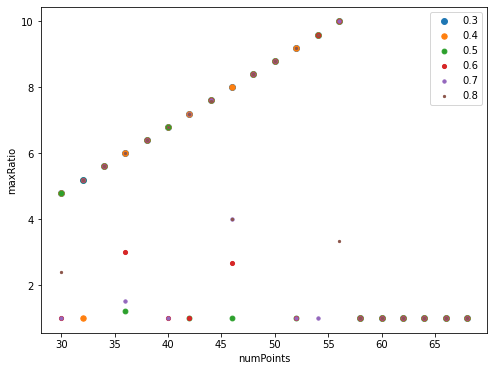

In [52]:
fig,ax=plt.subplots(figsize=(8,6))
i=0
for frac in np.linspace(0.3,0.8,6):
    frac=round(frac,1)
    ax.scatter(summary[summary['frac']==frac]['numPoints'],
               summary[summary['frac']==frac]['maxRatio'],s=35-i,alpha=1,label=frac)
    i+=6
ax.set_xlabel('numPoints')
ax.set_ylabel('maxRatio')
ax.legend()

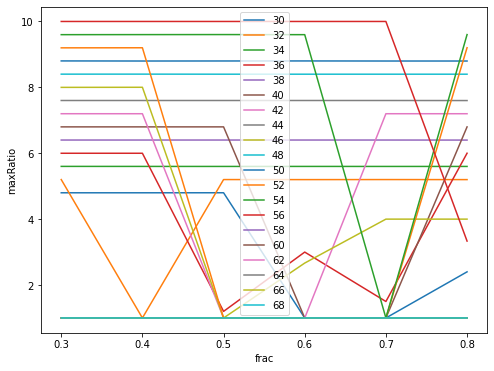

In [57]:
fig,ax=plt.subplots(figsize=(8,6))
i=0
for numPoints in range(30,70,2):
    frac=round(frac,1)
    ax.plot(summary[summary['numPoints']==numPoints]['frac'],
               summary[summary['numPoints']==numPoints]['maxRatio'],alpha=1,label=numPoints)
    i+=6
ax.set_xlabel('frac')
ax.set_ylabel('maxRatio')
ax.legend()

In [ ]:
import ipywidgets as widgets
widgets.IntSlider(
    value=7,
    min=0,
    max=10,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

In [ ]:
tab_contents = ['numPoints', 'Fraction of absent']
children = [widgets.Text(description=name) for name in tab_contents]
children[3]=widgets.IntSlider(
    value=7,
    min=0,
    max=10,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
tab = widgets.Tab()
tab.children = children
for ii in range(len(children)):
    tab.set_title(ii, f"tab_{ii}")
tab

In [ ]:
out1 = widgets.Output()
out2 = widgets.Output()
data1 = pd.DataFrame(np.random.normal(size = 50))
data2 = pd.DataFrame(np.random.normal(size = 100))

tab = widgets.Tab(children = [out1, out2])
tab.set_title(0, 'numPoints')
tab.set_title(1, 'fraction of absent')
display(tab)

with out1:
    fig1, axes1 = plt.subplots()
    data1.hist(ax = axes1)
    
    widgets.IntSlider(
    value=7,
    min=0,
    max=10,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
    plt.show(fig1)

with out2:
    fig2, axes2 = plt.subplots()
    data2.hist(ax = axes2)
    plt.show(fig2)